# Neutron Star Mass Distributions

This notebook shows the full analysis to compute mass distributions of neutron star subpopulations, using a double gaussian model, as well as statistical tests to compare the fits of different subpopulations.

In [66]:
# import necessary libraries
import jax.numpy as jnp
import jax.random as random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, log_likelihood, SA
import arviz as az
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import scipy.stats
import corner
import pandas as pd

import seaborn as sns
sns.set_context("paper", font_scale=1.5)

# Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'  # Options: 'serif', 'sans-serif', 'monospace'
plt.rcParams['font.serif'] = ['Times New Roman', 'DejaVu Serif', 'Bitstream Vera Serif']
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 18

# Loading and Plotting Data

Here we load in our Gaia NS and Double NS data and plot it.

In [67]:
# load in data
data = pd.read_csv("gaia_DNS_data.csv")

DNS = data[data['Type'] == 'DNS'] # Double neutron star, 'm1' is the recycled neutron star and 'm2' is the slow neutron star
Gaia = data[data['Type'] == 'Gaia'] 

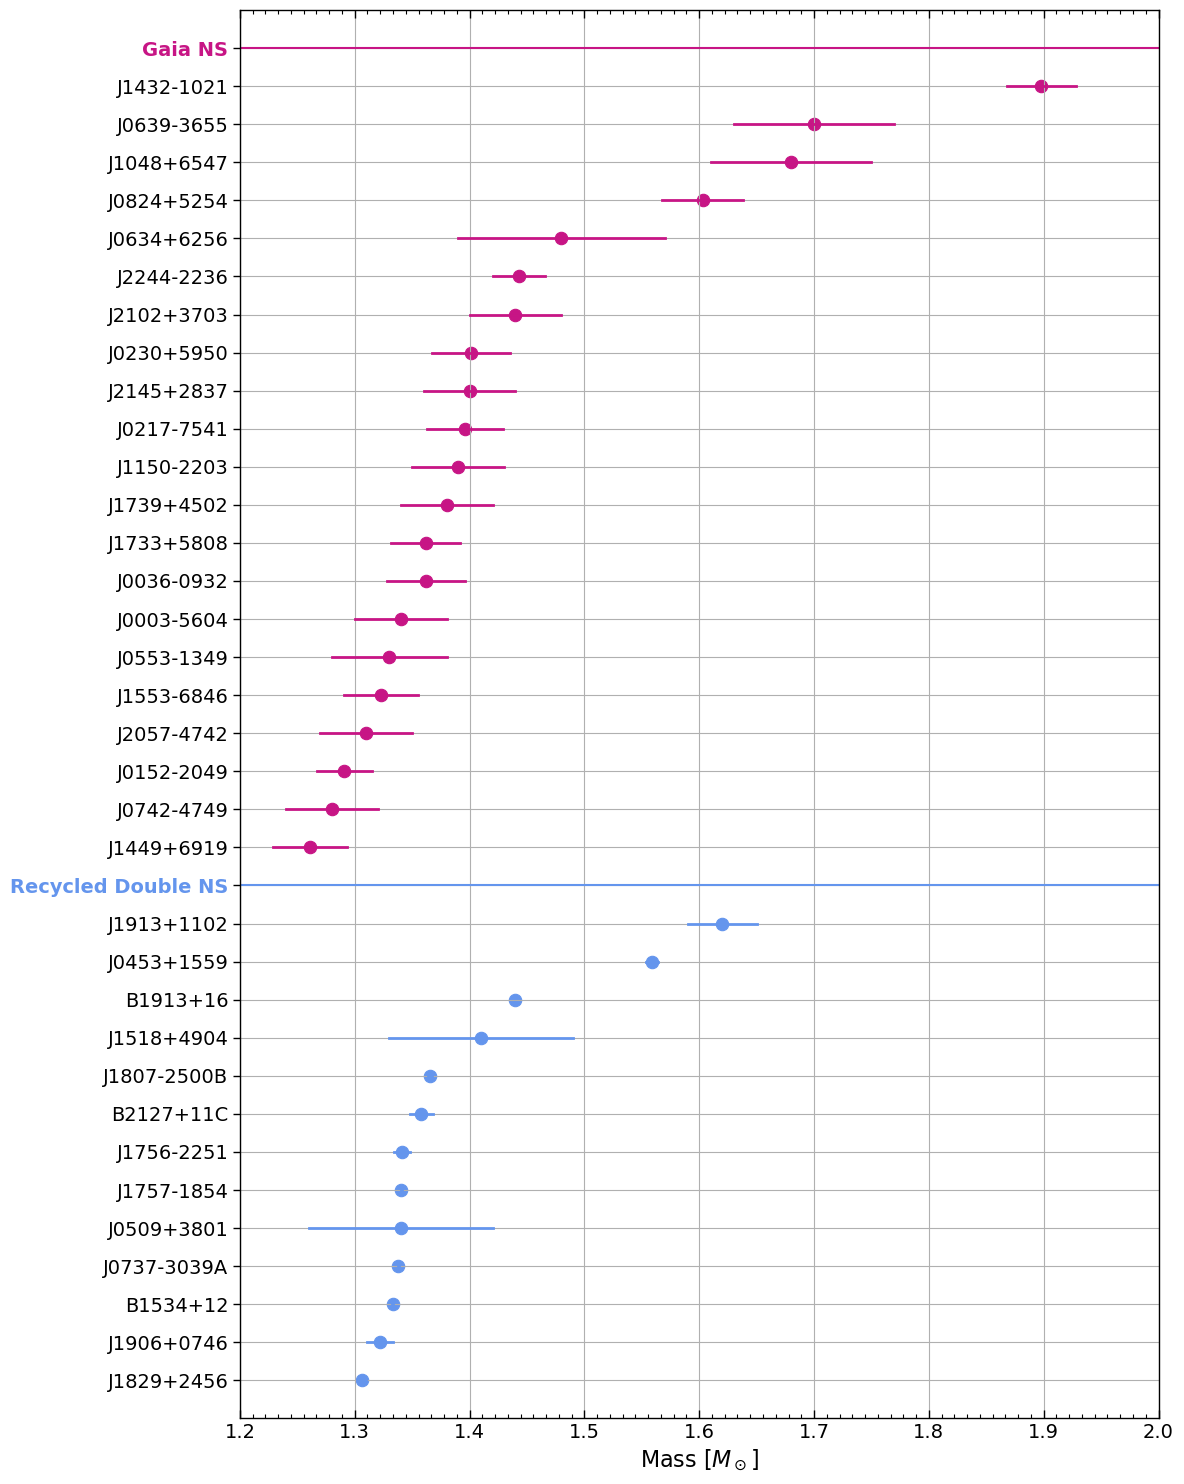

In [68]:
# Plot all data
data = pd.concat([Gaia, DNS], ignore_index=True)

# Sort data by 'Type' and 'm1'
data = data.sort_values(['Type', 'm1'], ascending=[False, False])

# Map 'type' to display names
type_display_names = {
    "Gaia": "Gaia NS",
    "DNS": "Recycled Double NS"
}
data['type_display'] = data['Type'].map(type_display_names)

# Create the header rows and mark data rows
plot_rows = []
for group_name, group_df in data.groupby('type_display'):
    header = pd.DataFrame({
        'Name': [group_name],
        'm1': [np.nan],
        'm1_err': [np.nan],
        'type': [None],
        'type_display': [group_name],
        'is_header': [True]
    })
    group_df = group_df.copy()
    group_df['is_header'] = False
    plot_rows.extend([header, group_df])

plot_data = pd.concat(plot_rows, ignore_index=True)
plot_data['ypos'] = range(len(plot_data))[::-1]

custom_palette = {
    "Gaia": "mediumvioletred",
    "DNS": "cornflowerblue"
}

group_color = {
    "Gaia NS": "mediumvioletred",
    "Recycled Double NS": "cornflowerblue"
}

fig, ax = plt.subplots(figsize=(12, 15))

for _, row in plot_data.iterrows():
    if not row['is_header']:
        color = custom_palette[row['Type']]
        ax.scatter(row['m1'], row['ypos'], color=color, s=80)
        ax.plot(
            [row['m1'] - row['m1_err'], row['m1'] + row['m1_err']],
            [row['ypos'], row['ypos']],
            color=color,
            linewidth=2
        )

# Horizontal separators for headers
for _, row in plot_data.iterrows():
    if row['is_header']:
        color = group_color.get(row['Name'], 'black')
        ax.axhline(y=row['ypos'], color=color, linewidth=1.5)

# Y-axis labels
ax.set_yticks(plot_data['ypos'])
ax.set_yticklabels(plot_data['Name'], fontsize=14)

plt.draw()
for label, is_header, row in zip(ax.get_yticklabels(), plot_data['is_header'], plot_data.itertuples()):
    if is_header:
        label.set_color(group_color.get(row.Name, "black"))
        label.set_fontweight("bold")

# X-axis formatting
ax.set_xlabel("Mass [$M_\\odot$]", fontsize=16)
ax.xaxis.set_ticks_position('both')
ax.tick_params(axis='x', which='both', direction='in', length=6)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(9))
ax.tick_params(axis='x', which='minor', direction='in', length=3)
plt.xticks(fontsize=14)

# Y-axis settings
ax.set_ylabel("")
ax.set_ylim(-1, len(plot_data))
ax.set_xlim(1.2, 2)
plt.grid()
plt.tight_layout()
plt.savefig("NS_mass_data.png", dpi=300, bbox_inches='tight')
plt.show()



# Model Functions

We define the prior bounds, double Gaussian model, and a function for running inference.

In [69]:
# agnostic priors that will be used for both the means of the gaussians and their standard deviations
priormin = 0.0
priormax = 2.1

In [70]:
def double_gaussian_uniform(data, err, prior=False):
    """
    Double Gaussian model with uniform priors.
    
    Parameters:
        data : array-like
            Observed data.
        err : array-like
            Observed errors.
        prior : bool
            If True, only sample from the prior distribution.
    """
    mu1 = numpyro.sample('mu1', dist.Uniform(priormin, priormax))
    mu2 = numpyro.sample('mu2', dist.Uniform(mu1, priormax))
    sigma1 = numpyro.sample('sigma1', dist.Uniform(priormin,priormax))
    sigma2 = numpyro.sample('sigma2', dist.Uniform(priormin, priormax))
    weight = numpyro.sample('weight', dist.Uniform(0, 1)) 

    if not prior:
        scale1 = jnp.sqrt(sigma1**2 + err**2)
        scale2 = jnp.sqrt(sigma2**2 + err**2)

        logp1 = dist.Normal(mu1, scale1).log_prob(data)
        logp2 = dist.Normal(mu2, scale2).log_prob(data)

        log_mix = jnp.logaddexp(jnp.log(weight) + logp1,
                                jnp.log1p(-weight) + logp2)
        numpyro.factor("obs", jnp.sum(log_mix))

        log_L = numpyro.deterministic("log_L", log_mix)

def run_inference(model, data, err, rng_key, num_warmup=10000, num_samples = 10000):
    """
    Run MCMC inference using the NUTS sampler.  

    Parameters:
        model : callable
            The mass distribution model to sample from.
        data : array-like
            Observed data.
        err : array-like
            Observed errors.
        rng_key : jax.random.PRNGKey
            Random key for JAX.
        num_warmup : int
            Number of warmup samples.
        num_samples : int
            Number of samples to draw from the posterior.
    Returns:
        mcmc : MCMC
            The MCMC object containing the samples.
    """
    kernel = NUTS(model)
    mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples)
    mcmc.run(rng_key, data=data, err=err)
    return mcmc

# Running Inference

Fitting a mass distribution to each subpopulation.

## Gaia

sample: 100%|██████████| 20000/20000 [00:03<00:00, 5812.98it/s, 7 steps of size 4.17e-01. acc. prob=0.82] 

sample: 100%|██████████| 2000/2000 [00:01<00:00, 1912.56it/s, 3 steps of size 5.91e-01. acc. prob=0.92]



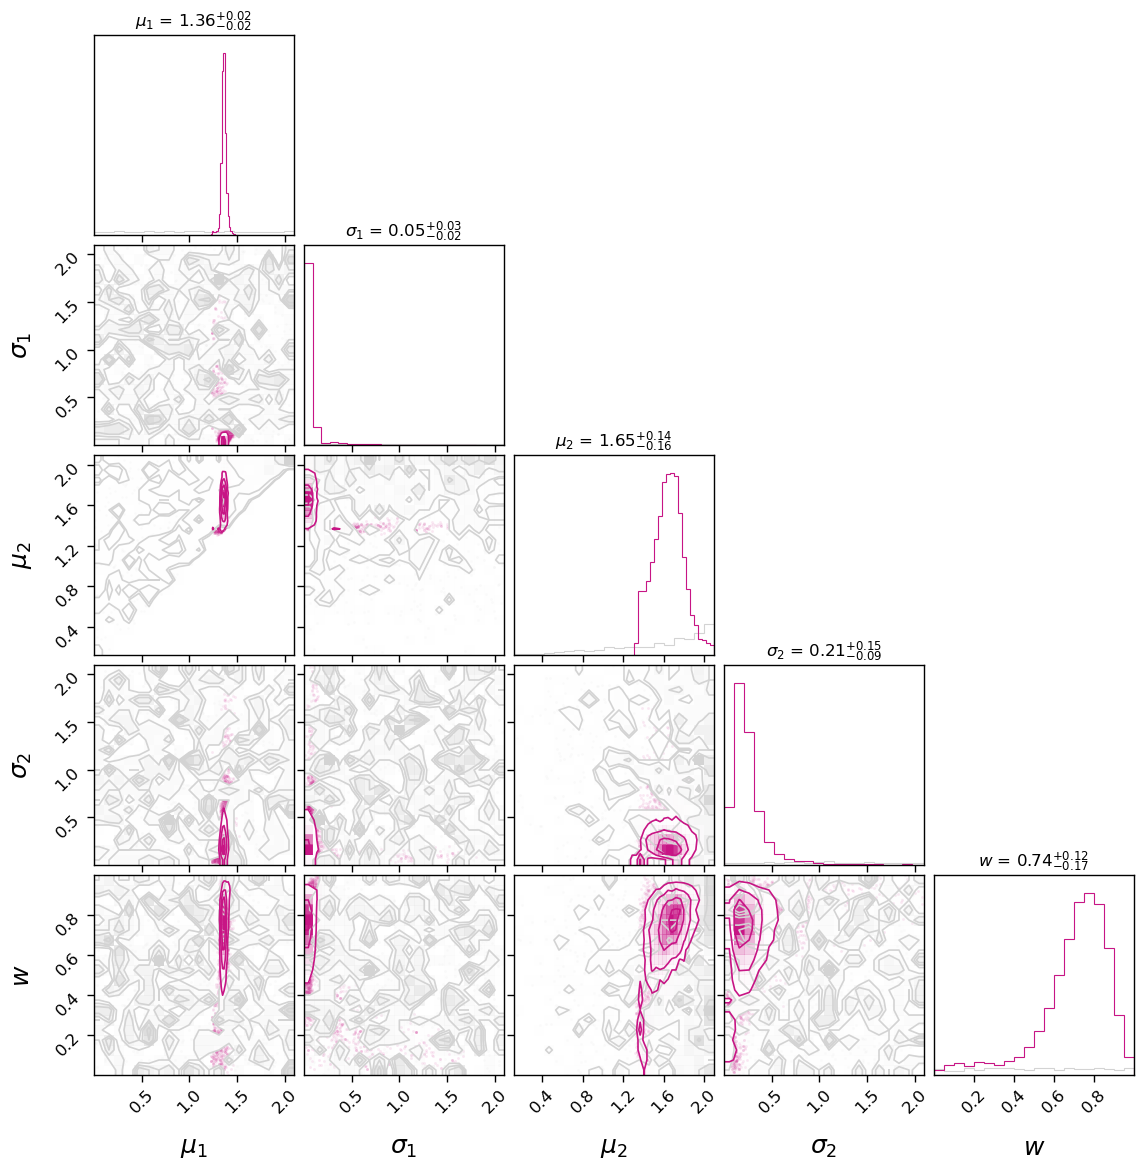

In [71]:
rng = random.PRNGKey(0) # set a random seed for reproducibility

gaiam1 =  Gaia['m1'].values
gaiam1_err = Gaia['m1_err'].values

# Fit two-component Gaussian - Uniform prior
rng, rng_infer_double = random.split(rng)
gaia_mcmc_double_uniform = run_inference(double_gaussian_uniform, gaiam1, gaiam1_err, rng_infer_double)
gaia_samples_double_uniform = az.from_numpyro(gaia_mcmc_double_uniform)

# Prior samples for double Gaussian model
rng, rng_prior_double = random.split(rng)
prior_sampler = MCMC(NUTS(double_gaussian_uniform), num_warmup=1000, num_samples=1000, progress_bar = True)
prior_sampler.run(rng_prior_double, gaiam1, gaiam1_err, prior=True)   
prior_samples = prior_sampler.get_samples()

### Corner plot    
# Priors
fig = corner.corner(
    prior_samples,
    var_names=['mu1', 'sigma1', 'mu2', 'sigma2', 'weight'],
    labels=[r"$\mu_1$", r"$\sigma_1$", r"$\mu_2$", r"$\sigma_2$", r"$w$"],
    color='lightgrey',
    show_titles=True,
    title_kwargs={"fontsize": 12},
    label_kwargs=dict(fontsize=18)
)
# Posteriors
corner.corner(
    gaia_samples_double_uniform,
    var_names=['mu1', 'sigma1', 'mu2', 'sigma2', 'weight'],
    labels=[r"$\mu_1$", r"$\sigma_1$", r"$\mu_2$", r"$\sigma_2$", r"$w$"],
    color='mediumvioletred',
    fig=fig,
    show_titles=True,
    title_kwargs={"fontsize": 12},
    label_kwargs=dict(fontsize=18)
)
plt.show()

In [72]:
# Calculate medians and HDI intervals
params = ['mu1', 'mu2', 'sigma1', 'sigma2', 'weight']
param_labels = [r'$\mu_1$', r'$\mu_2$', r'$\sigma_1$', r'$\sigma_2$', r'$w$']

# Initialize dictionaries to store the statistics
Gaia_medians = {}
Gaia_upper_errors = {}
Gaia_lower_errors = {}
Gaia_hdis = {}

print("Gaia Double Gaussian Fit Parameters (90% HDI):")
print("=" * 50)

for param, label in zip(params, param_labels):
    # Get posterior samples 
    samples = gaia_samples_double_uniform.posterior[param]
    
    # Calculate median and HDI
    median = np.median(samples)
    hdi = az.hdi(samples, hdi_prob=0.90)
    lower_hdi = float(hdi[param].values[0])  # Extract lower bound
    upper_hdi = float(hdi[param].values[1])  # Extract upper bound
    
    # Calculate asymmetric errors
    upper_error = upper_hdi - median
    lower_error = median - lower_hdi
    
    # Store the values
    Gaia_medians[param] = median
    Gaia_upper_errors[param] = upper_error
    Gaia_lower_errors[param] = lower_error
    Gaia_hdis[param] = (lower_hdi, upper_hdi)
    
    # Print in standard format: parameter = median +upper/-lower
    print(f"{label} = {median:.3f} +{upper_error:.3f}/-{lower_error:.3f}")
    print(f"    HDI: [{lower_hdi:.3f}, {upper_hdi:.3f}]")
    print()

Gaia Double Gaussian Fit Parameters (90% HDI):
$\mu_1$ = 1.360 +0.043/-0.037
    HDI: [1.323, 1.404]

$\mu_2$ = 1.651 +0.194/-0.292
    HDI: [1.359, 1.846]

$\sigma_1$ = 0.052 +0.068/-0.043
    HDI: [0.009, 0.119]

$\sigma_2$ = 0.214 +0.237/-0.185
    HDI: [0.029, 0.451]

$w$ = 0.737 +0.228/-0.268
    HDI: [0.469, 0.965]



## Recycled Double Neutron Stars

sample: 100%|██████████| 20000/20000 [00:03<00:00, 5239.38it/s, 31 steps of size 6.65e-02. acc. prob=0.90]

sample: 100%|██████████| 2000/2000 [00:01<00:00, 1926.24it/s, 3 steps of size 5.91e-01. acc. prob=0.92]



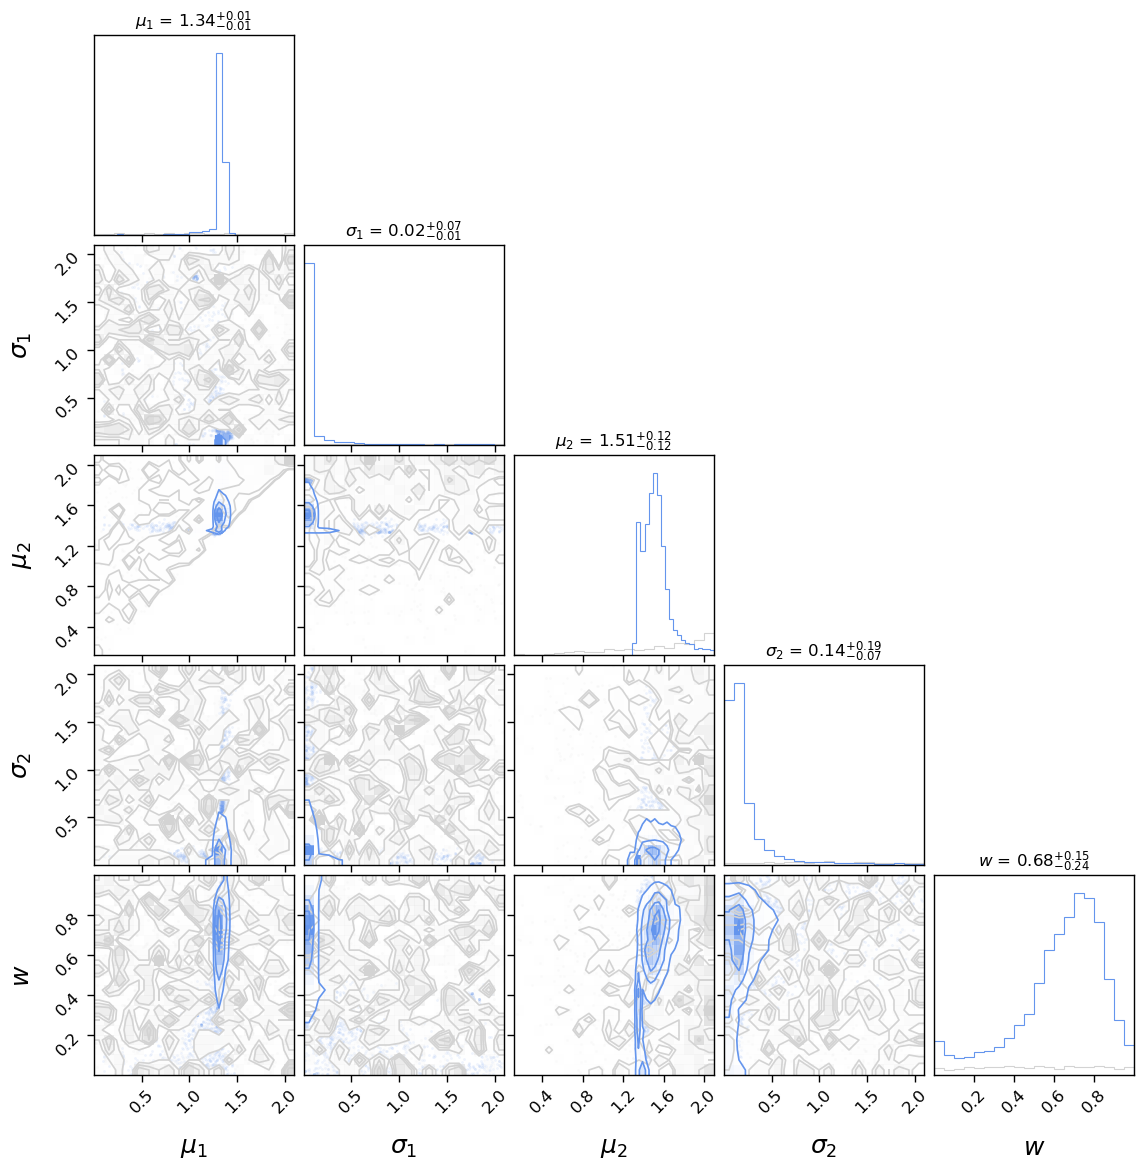

In [73]:
rng = random.PRNGKey(0) # set a random seed for reproducibility

DNSm1 = DNS['m1'].values
DNSm1_err = DNS['m1_err'].values

# Fit two-component Gaussian - Uniform prior
rng, rng_infer_double = random.split(rng)
DNS_mcmc_double_uniform = run_inference(double_gaussian_uniform, DNSm1, DNSm1_err, rng_infer_double)
DNS_samples_double_uniform = az.from_numpyro(DNS_mcmc_double_uniform)

# Prior samples for double Gaussian model
rng, rng_prior_double = random.split(rng)
prior_sampler = MCMC(NUTS(double_gaussian_uniform), num_warmup=1000, num_samples=1000, progress_bar = True)
prior_sampler.run(rng_prior_double, DNSm1, DNSm1_err, prior=True)   
prior_samples = prior_sampler.get_samples()

### Corner plot
# Priors
fig = corner.corner(
    prior_samples,
    var_names=['mu1', 'sigma1', 'mu2', 'sigma2', 'weight'],
    labels=[r"$\mu_1$", r"$\sigma_1$", r"$\mu_2$", r"$\sigma_2$", r"$w$"],
    color='lightgrey',
    show_titles=True,
    title_kwargs={"fontsize": 12},
    label_kwargs=dict(fontsize=18)
)
# Posteriors
corner.corner(
    DNS_samples_double_uniform,
    var_names=['mu1', 'sigma1', 'mu2', 'sigma2', 'weight'],
    labels=[r"$\mu_1$", r"$\sigma_1$", r"$\mu_2$", r"$\sigma_2$", r"$w$"],
    color='cornflowerblue',
    fig=fig,
    show_titles=True,
    title_kwargs={"fontsize": 12},
    label_kwargs=dict(fontsize=18)
)
plt.show()

In [74]:
# Compute medians and HDI intervals for DNS

params = ['mu1', 'mu2', 'sigma1', 'sigma2', 'weight']
param_labels = [r'$\mu_1$', r'$\mu_2$', r'$\sigma_1$', r'$\sigma_2$', r'$w$']

# Initialize dictionaries to store the statistics
DNS_medians = {}
DNS_upper_errors = {}
DNS_lower_errors = {}
DNS_hdis = {}

print("DNS Double Gaussian Fit Parameters (90% HDI):")
print("=" * 50)

for param, label in zip(params, param_labels):  
    # Get posterior samples 
    samples = DNS_samples_double_uniform.posterior[param]
    
    # Calculate median and HDI
    median = np.median(samples)
    hdi = az.hdi(samples, hdi_prob=0.90)
    lower_hdi = float(hdi[param].values[0])  
    upper_hdi = float(hdi[param].values[1])  
    
    # Calculate asymmetric errors
    upper_error = upper_hdi - median
    lower_error = median - lower_hdi
    
    # Store the values
    DNS_medians[param] = median
    DNS_upper_errors[param] = upper_error
    DNS_lower_errors[param] = lower_error
    DNS_hdis[param] = (lower_hdi, upper_hdi)
    
    # Print in standard format: parameter = median +upper/-lower
    print(f"{label} = {median:.3f} +{upper_error:.3f}/-{lower_error:.3f}")
    print(f"    HDI: [{lower_hdi:.3f}, {upper_hdi:.3f}]")
    print() 

DNS Double Gaussian Fit Parameters (90% HDI):
$\mu_1$ = 1.339 +0.066/-0.050
    HDI: [1.289, 1.405]

$\mu_2$ = 1.507 +0.188/-0.179
    HDI: [1.328, 1.694]

$\sigma_1$ = 0.025 +0.219/-0.021
    HDI: [0.003, 0.244]

$\sigma_2$ = 0.141 +0.328/-0.140
    HDI: [0.001, 0.469]

$w$ = 0.679 +0.321/-0.345
    HDI: [0.334, 1.000]



## Combination of rDNS and Gaia

sample: 100%|██████████| 20000/20000 [00:03<00:00, 6197.77it/s, 7 steps of size 4.90e-01. acc. prob=0.89]

sample: 100%|██████████| 2000/2000 [00:00<00:00, 2000.95it/s, 3 steps of size 5.91e-01. acc. prob=0.92]



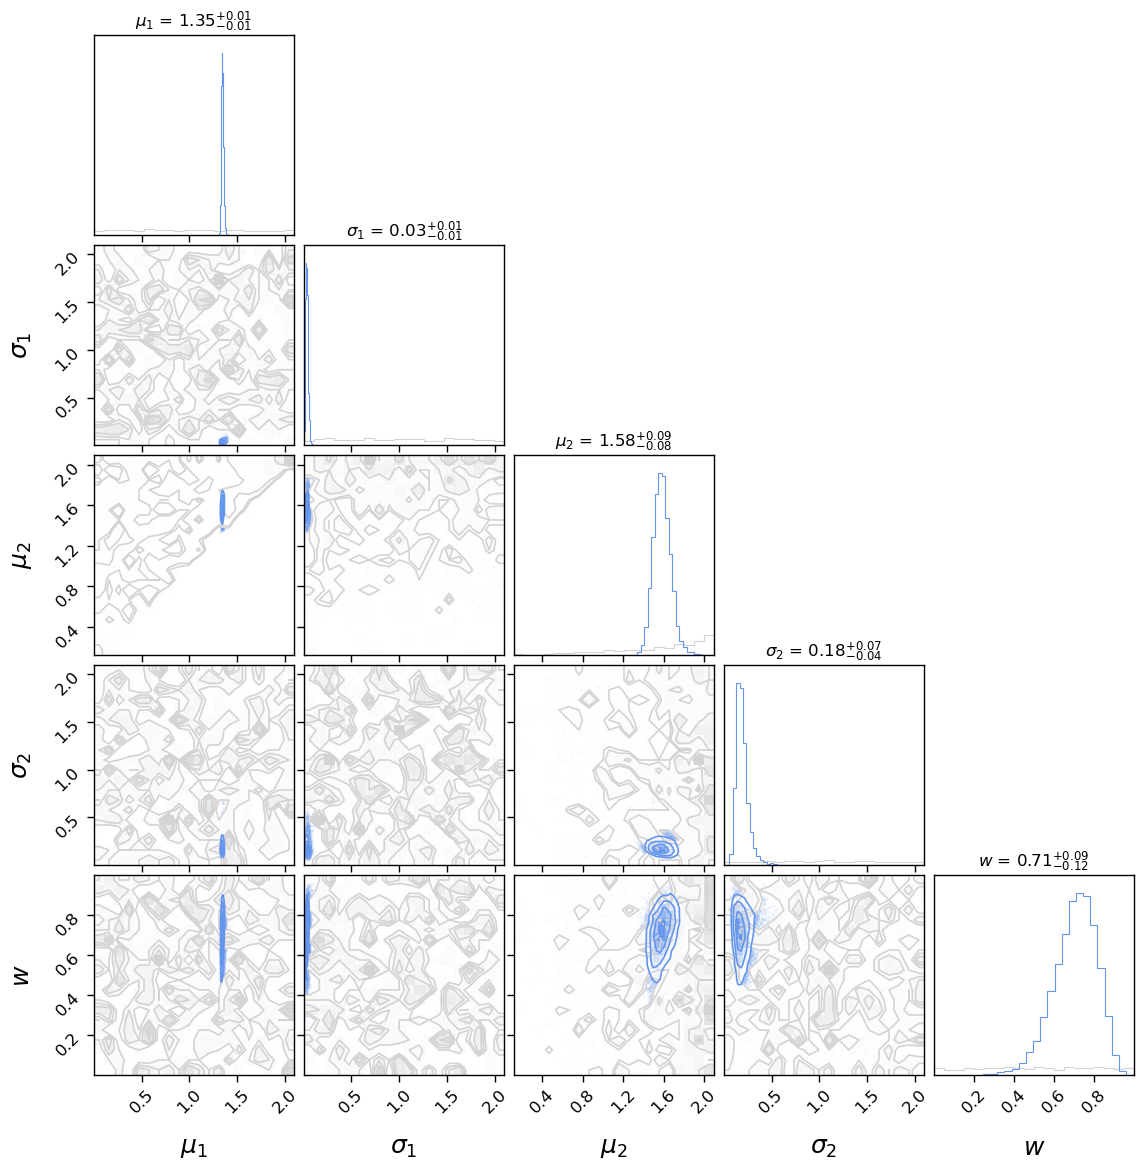

In [75]:
rng = random.PRNGKey(0) # set a random seed for reproducibility

combinedm1 = np.concatenate([DNS['m1'].values, Gaia['m1'].values])
combinedm1_err = np.concatenate([DNS['m1_err'].values, Gaia['m1_err'].values])

# Fit two-component Gaussian - Uniform prior
rng, rng_infer_double = random.split(rng)
combined_mcmc_double_uniform = run_inference(double_gaussian_uniform, combinedm1, combinedm1_err, rng_infer_double)
combined_samples_double_uniform = az.from_numpyro(combined_mcmc_double_uniform)

# Prior samples for double Gaussian model
rng, rng_prior_double = random.split(rng)
prior_sampler = MCMC(NUTS(double_gaussian_uniform), num_warmup=1000, num_samples=1000, progress_bar = True)
prior_sampler.run(rng_prior_double, combinedm1, combinedm1_err, prior=True)
prior_samples = prior_sampler.get_samples()

### Corner plot
# Priors
fig = corner.corner(
    prior_samples,
    var_names=['mu1', 'sigma1', 'mu2', 'sigma2', 'weight'],
    labels=[r"$\mu_1$", r"$\sigma_1$", r"$\mu_2$", r"$\sigma_2$", r"$w$"],
    color='lightgrey',
    show_titles=True,
    title_kwargs={"fontsize": 12},
    label_kwargs=dict(fontsize=18)
)
# Posteriors
corner.corner(
    combined_samples_double_uniform,
    var_names=['mu1', 'sigma1', 'mu2', 'sigma2', 'weight'],
    labels=[r"$\mu_1$", r"$\sigma_1$", r"$\mu_2$", r"$\sigma_2$", r"$w$"],
    color='cornflowerblue',
    fig=fig,
    show_titles=True,
    title_kwargs={"fontsize": 12},
    label_kwargs=dict(fontsize=18)
)
plt.show()

In [76]:
# Compute medians and HDI intervals for combined data

params = ['mu1', 'mu2', 'sigma1', 'sigma2', 'weight']
param_labels = [r'$\mu_1$', r'$\mu_2$', r'$\sigma_1$', r'$\sigma_2$', r'$w$']

# Initialize dictionaries to store the statistics
combined_medians = {}
combined_upper_errors = {}
combined_lower_errors = {}
combined_hdis = {}

print("Combined Double Gaussian Fit Parameters (90% HDI):")
print("=" * 50)

for param, label in zip(params, param_labels):  
    # Get posterior samples 
    samples = combined_samples_double_uniform.posterior[param]
    
    # Calculate median and HDI
    median = np.median(samples)
    hdi = az.hdi(samples, hdi_prob=0.90)
    lower_hdi = float(hdi[param].values[0])  
    upper_hdi = float(hdi[param].values[1])  
    
    # Calculate asymmetric errors
    upper_error = upper_hdi - median
    lower_error = median - lower_hdi
    
    # Store the values
    combined_medians[param] = median
    combined_upper_errors[param] = upper_error
    combined_lower_errors[param] = lower_error
    combined_hdis[param] = (lower_hdi, upper_hdi)

    # Print in standard format: parameter = median +upper/-lower
    print(f"{label} = {median:.3f} +{upper_error:.3f}/-{lower_error:.3f}")
    print(f"    HDI: [{lower_hdi:.3f}, {upper_hdi:.3f}]")
    print() 

Combined Double Gaussian Fit Parameters (90% HDI):
$\mu_1$ = 1.346 +0.019/-0.017
    HDI: [1.329, 1.365]

$\mu_2$ = 1.581 +0.133/-0.139
    HDI: [1.442, 1.714]

$\sigma_1$ = 0.032 +0.020/-0.019
    HDI: [0.012, 0.052]

$\sigma_2$ = 0.179 +0.105/-0.082
    HDI: [0.097, 0.284]

$w$ = 0.714 +0.163/-0.174
    HDI: [0.540, 0.877]



# Comparison of Mass Distributions

Plotting the distributions together and computing the Jensen Shannon divergence as well as the earth mover's distance.

In [77]:
def plot_cdf(m, uerr, lerr):
    """
    Returns useful arrays to plot the cumulative distribution function (CDF) of the mass distribution.  
    Parameters:
        m : array-like
            Mass values.
        uerr : array-like
            Upper errors.
        lerr : array-like
            Lower errors.

    Returns:
        masses : array-like
            Sorted mass values.
        uerrors : array-like
            Sorted upper errors.
        lerrors : array-like
            Sorted lower errors.
        bins : list
            List of bins for the histogram.
    """

    sorted_idx = np.argsort(m)
    masses = m[sorted_idx] 
    uerrors = uerr[sorted_idx]
    lerrors = lerr[sorted_idx]
    
    masses = masses[~np.isnan(masses)]
    uerrors = uerrors[~np.isnan(uerrors)]
    lerrors = lerrors[~np.isnan(lerrors)]

    bins = list(masses)
    bins.append(max(masses))
    bins.insert(0,0)
    
    return(masses, uerrors, lerrors, bins)

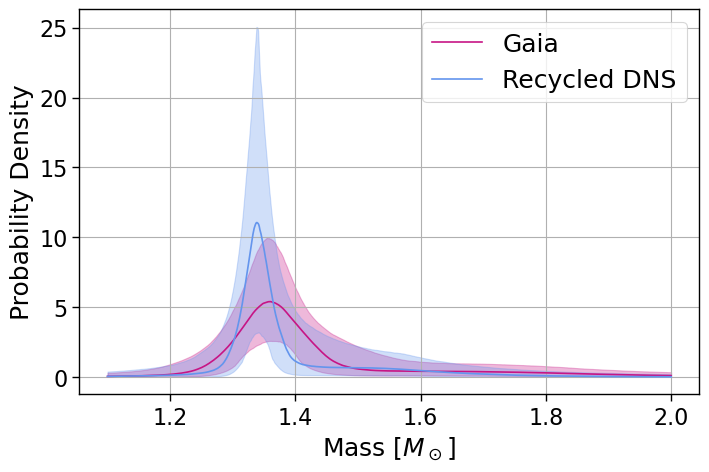

In [ ]:
### Plot the mass distributions of the recycled DNS and Gaia populations

plt.figure(figsize=(8,5))
x = np.linspace(1.1, 2, 1000) # mass array for plotting

# Get the raw MCMC samples for easier indexing
gaia_mcmc_samples = gaia_mcmc_double_uniform.get_samples()
DNS_mcmc_samples = DNS_mcmc_double_uniform.get_samples()
combined_mcmc_samples = combined_mcmc_double_uniform.get_samples()

# Plot the credible bands 
gaiacurves = np.array([
    gaia_mcmc_samples['weight'][i] * scipy.stats.norm.pdf(x, loc=gaia_mcmc_samples['mu1'][i], scale=gaia_mcmc_samples['sigma1'][i]) +
    (1 - gaia_mcmc_samples['weight'][i]) * scipy.stats.norm.pdf(x, loc=gaia_mcmc_samples['mu2'][i], scale=gaia_mcmc_samples['sigma2'][i])
    for i in range(len(gaia_mcmc_samples['mu1']))
])

DNScurves = np.array([
    DNS_mcmc_samples['weight'][i] * scipy.stats.norm.pdf(x, loc=DNS_mcmc_samples['mu1'][i], scale=DNS_mcmc_samples['sigma1'][i]) +
    (1 - DNS_mcmc_samples['weight'][i]) * scipy.stats.norm.pdf(x, loc=DNS_mcmc_samples['mu2'][i], scale=DNS_mcmc_samples['sigma2'][i])
    for i in range(len(DNS_mcmc_samples['mu1']))
])

combinedcurves = np.array([
    combined_mcmc_samples['weight'][i] * scipy.stats.norm.pdf(x, loc=combined_mcmc_samples['mu1'][i], scale=combined_mcmc_samples['sigma1'][i]) +
    (1 - combined_mcmc_samples['weight'][i]) * scipy.stats.norm.pdf(x, loc=combined_mcmc_samples['mu2'][i], scale=combined_mcmc_samples['sigma2'][i])
    for i in range(len(combined_mcmc_samples['mu1']))
])

plt.plot(x, np.median(gaiacurves, axis=0), alpha=1, color='mediumvioletred', label='Gaia')
plt.fill_between(x, np.percentile(gaiacurves, 5, axis=0), np.percentile(gaiacurves, 95, axis=0), alpha=0.3, color='mediumvioletred')

plt.plot(x, np.median(DNScurves, axis=0), alpha=1, color='cornflowerblue', label='Recycled DNS')
plt.fill_between(x, np.percentile(DNScurves, 5, axis=0), np.percentile(DNScurves, 95, axis=0), alpha=0.3, color='cornflowerblue')

# plt.plot(x, np.median(combinedcurves, axis=0), alpha=1, color='purple', label='Combined')
# plt.fill_between(x, np.percentile(combinedcurves, 5, axis=0), np.percentile(combinedcurves, 95, axis=0), alpha=0.3, color='purple')

plt.grid()
plt.xlabel("Mass [$M_\odot]$", fontsize=18)
plt.ylabel("Probability Density", fontsize=18)
plt.legend(fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.savefig("mass_dist_fits.png", dpi=300, bbox_inches='tight')
plt.show()

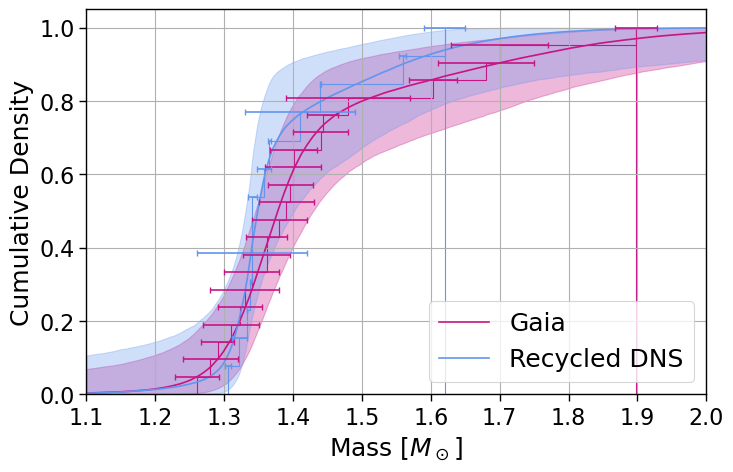

In [153]:
# Plot the CDFs

# Plot the credible bands 
gaiacurves = np.array([
    gaia_mcmc_samples['weight'][i] * scipy.stats.norm.cdf(x, loc=gaia_mcmc_samples['mu1'][i], scale=gaia_mcmc_samples['sigma1'][i]) +
    (1 - gaia_mcmc_samples['weight'][i]) * scipy.stats.norm.cdf(x, loc=gaia_mcmc_samples['mu2'][i], scale=gaia_mcmc_samples['sigma2'][i])
    for i in range(len(gaia_mcmc_samples['mu1']))
])

DNScurves = np.array([
    DNS_mcmc_samples['weight'][i] * scipy.stats.norm.cdf(x, loc=DNS_mcmc_samples['mu1'][i], scale=DNS_mcmc_samples['sigma1'][i]) +
    (1 - DNS_mcmc_samples['weight'][i]) * scipy.stats.norm.cdf(x, loc=DNS_mcmc_samples['mu2'][i], scale=DNS_mcmc_samples['sigma2'][i])
    for i in range(len(DNS_mcmc_samples['mu1']))
]) 

combinedcurves = np.array([
    combined_mcmc_samples['weight'][i] * scipy.stats.norm.cdf(x, loc=combined_mcmc_samples['mu1'][i], scale=combined_mcmc_samples['sigma1'][i]) +
    (1 - combined_mcmc_samples['weight'][i]) * scipy.stats.norm.cdf(x, loc=combined_mcmc_samples['mu2'][i], scale=combined_mcmc_samples['sigma2'][i])
    for i in range(len(combined_mcmc_samples['mu1']))
])

# Plot median and percentile bands
plt.figure(figsize=(8,5))
plt.plot(x, np.median(gaiacurves, axis=0), alpha=1, color='mediumvioletred', label='Gaia')
plt.fill_between(x, np.percentile(gaiacurves, 5, axis=0), np.percentile(gaiacurves, 95, axis=0), alpha=0.3, color='mediumvioletred')

plt.plot(x, np.median(DNScurves, axis=0), alpha=1, color='cornflowerblue', label='Recycled DNS')
plt.fill_between(x, np.percentile(DNScurves, 5, axis=0), np.percentile(DNScurves, 95, axis=0), alpha=0.3, color='cornflowerblue')

# Plot data 
gaia_masses, gaia_uerrors, gaia_lerrors, gaia_bins = plot_cdf(gaiam1,gaiam1_err,gaiam1_err)
DNS_masses, DNS_uerrors, DNS_lerrors, DNS_bins = plot_cdf(DNSm1,DNSm1_err,DNSm1_err)

plt.stairs(np.array(range(len(gaia_masses)+1))/len(gaia_masses),gaia_bins, alpha =1 ,color='mediumvioletred')
plt.errorbar(gaia_masses, np.array(range(len(gaia_masses)+1))[1:]/len(gaia_masses), xerr = (gaia_uerrors, gaia_lerrors), color='mediumvioletred', ls = "None", capsize = 2)

plt.stairs(np.array(range(len(DNS_masses)+1))/len(DNS_masses),DNS_bins, alpha =1 ,color='cornflowerblue')
plt.errorbar(DNS_masses, np.array(range(len(DNS_masses)+1))[1:]/len(DNS_masses), xerr = (DNS_uerrors, DNS_lerrors), color='cornflowerblue', ls = "None", capsize = 2)

plt.grid()
plt.xlabel("Mass [$M_\odot$]", fontsize=18)
plt.ylabel("Cumulative Density", fontsize=18)
plt.xlim(1.1, 2)
plt.legend(loc='lower right', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.savefig("cdf_fits.png", dpi=300, bbox_inches='tight')
plt.show()

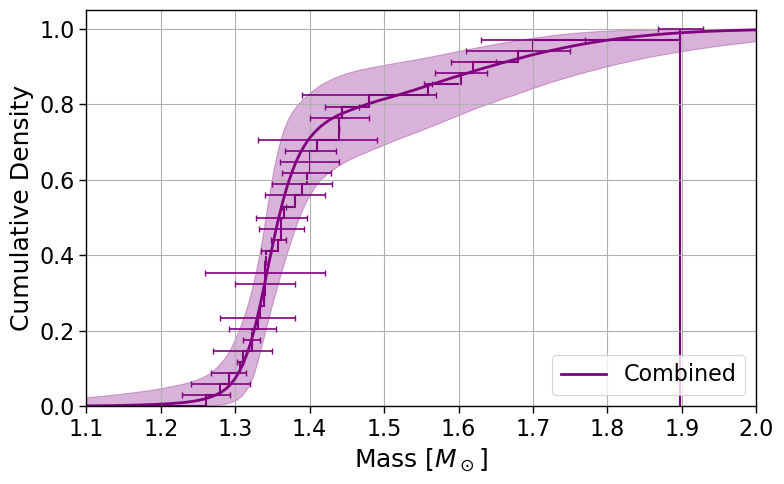

In [ ]:
#Combined CDF only

combined_masses = np.concatenate([gaiam1, DNSm1])
combined_uerrors = np.concatenate([gaiam1_err, DNSm1_err])
combined_lerrors = np.concatenate([gaiam1_err, DNSm1_err]) 

combined_masses, combined_uerrors, combined_lerrors, combined_bins = plot_cdf(
    combined_masses, combined_uerrors, combined_lerrors
)

plt.figure(figsize=(8,5))

plt.plot(x, np.median(combinedcurves, axis=0), color='purple', lw=2, label='Combined')
plt.fill_between(
    x,
    np.percentile(combinedcurves, 5, axis=0),
    np.percentile(combinedcurves, 95, axis=0),
    color='purple',
    alpha=0.3
)

plt.stairs(np.arange(len(combined_masses)+1)/len(combined_masses), combined_bins,
           color='purple', lw=1.5)
plt.errorbar(
    combined_masses,
    np.arange(1, len(combined_masses)+1)/len(combined_masses),
    xerr=(combined_uerrors, combined_lerrors),
    color='purple',
    ls='none',
    capsize=2
)

plt.grid()
plt.xlabel("Mass [$M_\odot$]", fontsize=18)
plt.ylabel("Cumulative Density", fontsize=18)
plt.xlim(1.1, 2)
plt.legend(fontsize=16, loc='lower right')
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout()
plt.savefig("combined_cdf.png", dpi=300, bbox_inches='tight')
plt.show()


In [94]:
# What fraction of masses are above different mass thresholds in each population?
mass_thresholds = [1.4, 1.5, 1.6]
for mass_threshold in mass_thresholds:
    print(f"Fraction of masses above {mass_threshold:.2f} solar masses:")

    # find the index in x array closest to the threshold
    threshold_idx = np.argmin(np.abs(x - mass_threshold))
    actual_threshold = x[threshold_idx]
    gaia_cdf_at_thresh = gaiacurves[:, threshold_idx]
    dns_cdf_at_thresh = DNScurves[:, threshold_idx]
    combined_cdf_at_thresh = combinedcurves[:, threshold_idx]

    # Compute fractions above threshold (1 - CDF)
    gaia_fractions_above_thresh = 1 - gaia_cdf_at_thresh
    dns_fractions_above_thresh = 1 - dns_cdf_at_thresh
    combined_fractions_above_thresh = 1 - combined_cdf_at_thresh

    # Compute statistics
    gaia_median_fraction = np.median(gaia_fractions_above_thresh)
    gaia_hdi_fraction = np.percentile(gaia_fractions_above_thresh, [5, 95])
    dns_median_fraction = np.median(dns_fractions_above_thresh)
    dns_hdi_fraction = np.percentile(dns_fractions_above_thresh, [5, 95])
    combined_median_fraction = np.median(combined_fractions_above_thresh)
    combined_hdi_fraction = np.percentile(combined_fractions_above_thresh, [5, 95])

    print(f"Gaia NS: {gaia_median_fraction:.3f} [{gaia_hdi_fraction[0]:.3f}, {gaia_hdi_fraction[1]:.3f}] (90% HDI)")
    print(f"Recycled DNS: {dns_median_fraction:.3f} [{dns_hdi_fraction[0]:.3f}, {dns_hdi_fraction[1]:.3f}] (90% HDI)")
    print(f"Combined: {combined_median_fraction:.3f} [{combined_hdi_fraction[0]:.3f}, {combined_hdi_fraction[1]:.3f}] (90% HDI)")

    # What percentage of the time is the Gaia fraction greater than the DNS fraction?
    greater_count = np.sum(gaia_fractions_above_thresh > dns_fractions_above_thresh)
    percentage_greater = (greater_count / len(gaia_fractions_above_thresh)) * 100
    print(f"Percentage of times Gaia fraction > DNS fraction: {percentage_greater:.1f}%")
    print()

Fraction of masses above 1.40 solar masses:
Gaia NS: 0.390 [0.209, 0.597] (90% HDI)
Recycled DNS: 0.251 [0.093, 0.505] (90% HDI)
Combined: 0.289 [0.170, 0.440] (90% HDI)
Percentage of times Gaia fraction > DNS fraction: 78.5%

Fraction of masses above 1.50 solar masses:
Gaia NS: 0.200 [0.083, 0.368] (90% HDI)
Recycled DNS: 0.147 [0.044, 0.326] (90% HDI)
Combined: 0.186 [0.095, 0.306] (90% HDI)
Percentage of times Gaia fraction > DNS fraction: 68.0%

Fraction of masses above 1.60 solar masses:
Gaia NS: 0.143 [0.050, 0.287] (90% HDI)
Recycled DNS: 0.072 [0.010, 0.223] (90% HDI)
Combined: 0.124 [0.058, 0.228] (90% HDI)
Percentage of times Gaia fraction > DNS fraction: 76.3%



In [142]:
# Comparing credible region overlap of population parameters

gaia_posterior = gaia_samples_double_uniform.posterior
dns_posterior = DNS_samples_double_uniform.posterior
combined_posterior = combined_samples_double_uniform

params = ['mu1', 'mu2', 'sigma1', 'sigma2', 'weight']

for param in params:
    print(param)
    
    gaia_samples = gaia_posterior[param].stack(sample=("chain","draw")).values
    dns_samples = dns_posterior[param].stack(sample=("chain","draw")).values
    combined_samples = combined_posterior.posterior[param].stack(sample=("chain","draw")).values
    
    gaia_median = np.median(gaia_samples)
    dns_median = np.median(dns_samples)
    gaia_std = np.std(gaia_samples)
    dns_std = np.std(dns_samples)
    combined_median = np.median(combined_samples)
    combined_std = np.std(combined_samples)

    # HDI calculation (90%)
    gaia_hdi = az.hdi(gaia_samples, hdi_prob=0.9)
    dns_hdi = az.hdi(dns_samples, hdi_prob=0.9)
    combined_hdi = az.hdi(combined_samples, hdi_prob=0.9)
    gaia_range = gaia_hdi[1] - gaia_hdi[0]
    dns_range = dns_hdi[1] - dns_hdi[0]
    combined_range = combined_hdi[1] - combined_hdi[0]

    print(f"Gaia NS: [HDI: {gaia_hdi[0]:.3f}, {gaia_hdi[1]:.3f}], Range = {gaia_range:.3f}")
    print(f"Recycled DNS: [HDI: {dns_hdi[0]:.3f}, {dns_hdi[1]:.3f}], Range = {dns_range:.3f}")
    print(f"Combined: [HDI: {combined_hdi[0]:.3f}, {combined_hdi[1]:.3f}], Range = {combined_range:.3f}")

    # HDI overlap
    overlap_start = max(gaia_hdi[0], dns_hdi[0])
    overlap_end = min(gaia_hdi[1], dns_hdi[1])
    overlap_size = overlap_end - overlap_start
    overlap_fraction = overlap_size / min(gaia_range, dns_range)
    print(f"HDI Overlap: ({overlap_size:.3f} units, {overlap_fraction*100:.1f}% of smaller hdi range)")
    print("Joint parameter range:", min(gaia_hdi[0], dns_hdi[0]), "to", max(gaia_hdi[1], dns_hdi[1]))
    print("Combined fit range:", combined_hdi[0], "to", combined_hdi[1])

    # Posterior difference
    N = 100000  # number of random pairs
    gaia_draws = np.random.choice(gaia_samples, size=N, replace=True)
    dns_draws  = np.random.choice(dns_samples,  size=N, replace=True)

    prob_gaia_greater = np.mean(gaia_draws > dns_draws)
    print(f"P(Gaia > DNS) ≈ {prob_gaia_greater:.3f}")
    
    print()

mu1
Gaia NS: [HDI: 1.323, 1.404], Range = 0.081
Recycled DNS: [HDI: 1.289, 1.405], Range = 0.116
Combined: [HDI: 1.329, 1.365], Range = 0.036
HDI Overlap: (0.081 units, 100.0% of smaller hdi range)
Joint parameter range: 1.2889708 to 1.4048275
Combined fit range: 1.3294193 to 1.3653631
P(Gaia > DNS) ≈ 0.801

mu2
Gaia NS: [HDI: 1.359, 1.846], Range = 0.487
Recycled DNS: [HDI: 1.328, 1.694], Range = 0.366
Combined: [HDI: 1.442, 1.714], Range = 0.272
HDI Overlap: (0.335 units, 91.6% of smaller hdi range)
Joint parameter range: 1.328057 to 1.8456761
Combined fit range: 1.4422635 to 1.7138102
P(Gaia > DNS) ≈ 0.753

sigma1
Gaia NS: [HDI: 0.009, 0.119], Range = 0.110
Recycled DNS: [HDI: 0.003, 0.244], Range = 0.240
Combined: [HDI: 0.012, 0.052], Range = 0.039
HDI Overlap: (0.110 units, 100.0% of smaller hdi range)
Joint parameter range: 0.0032595212 to 0.24351983
Combined fit range: 0.012194442 to 0.051509764
P(Gaia > DNS) ≈ 0.746

sigma2
Gaia NS: [HDI: 0.029, 0.451], Range = 0.422
Recycled D

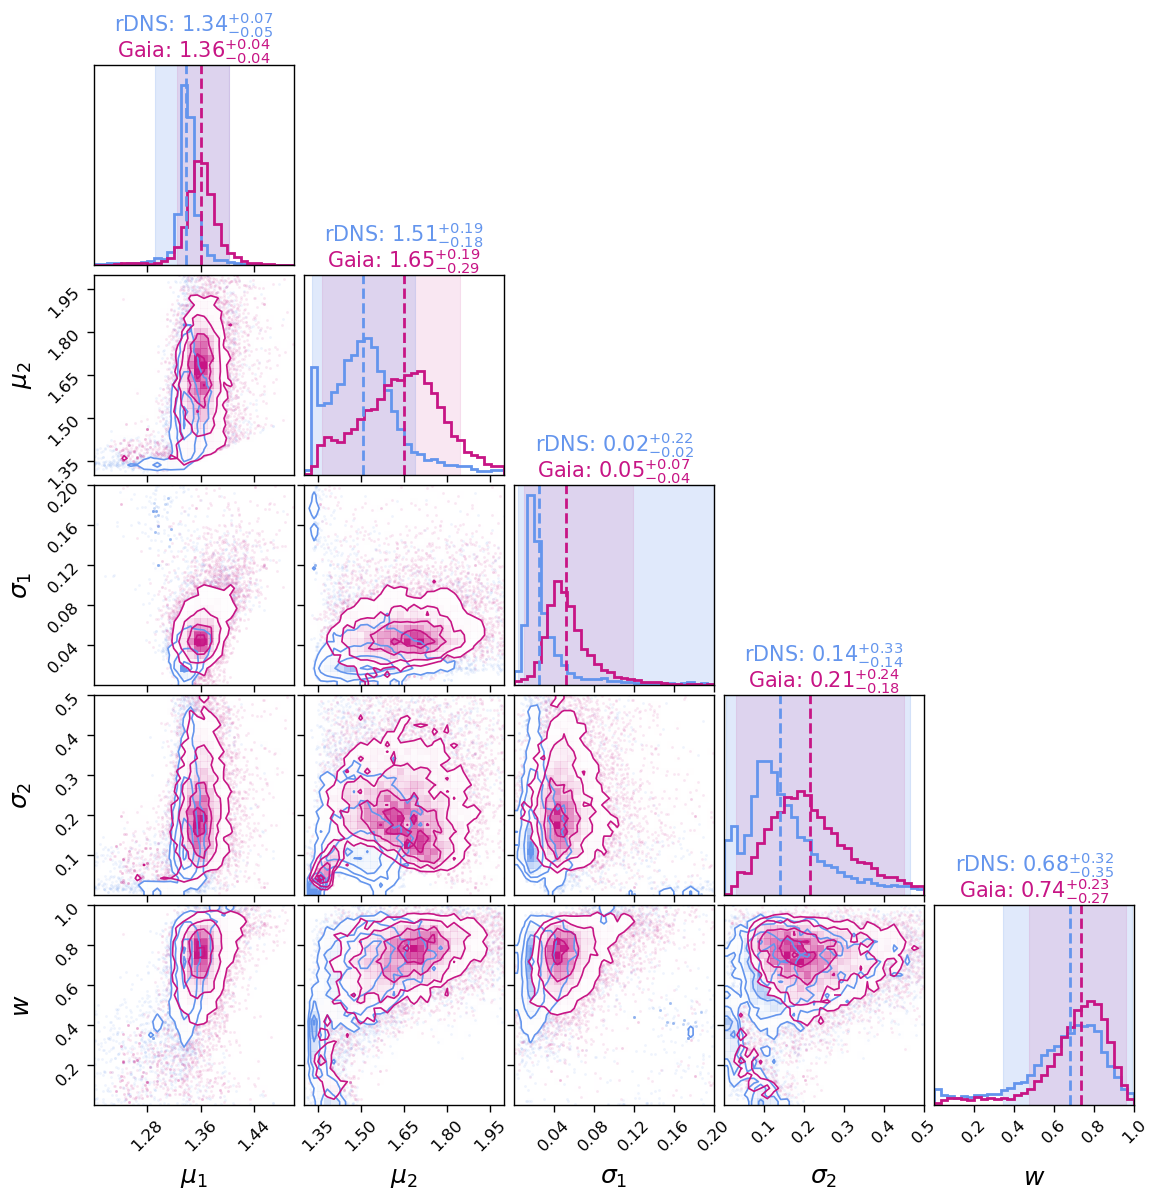

In [ ]:
### Corner plot with HDI shading on 1D marginals
ranges = [(1.2, 1.5),    # mu1 range
          (1.3, 2.0),    # mu2 range  
          (0.0, 0.2),    # sigma1 range
          (0.0, 0.5),    # sigma2 range
          (0.0, 1.0)]    # weight range


fig = corner.corner(
    DNS_samples_double_uniform,
    var_names=params,
    labels=param_labels,
    color='cornflowerblue',
    show_titles=False,
    label_kwargs=dict(fontsize=18),
    range=ranges,
    bins=30,   
    hist_kwargs=dict(density=True, lw=2)
)

corner.corner(
    gaia_samples_double_uniform,
    var_names=params,
    labels=param_labels,
    color='mediumvioletred',
    fig=fig,
    show_titles=False,
    label_kwargs=dict(fontsize=18),
    range=ranges,
    bins=30,
    hist_kwargs=dict(density=True, lw=2)
)

ndim = len(params)
axes = np.array(fig.axes).reshape((ndim, ndim))

for i, param in enumerate(params):
    ax = axes[i, i]

    dns_samples = DNS_samples_double_uniform.posterior[param].stack(sample=("chain", "draw")).values
    gaia_samples = gaia_samples_double_uniform.posterior[param].stack(sample=("chain", "draw")).values

    # Compute HDIs
    dns_hdi = az.hdi(dns_samples, hdi_prob=0.9)
    gaia_hdi = az.hdi(gaia_samples, hdi_prob=0.9)

    xs = np.linspace(ranges[i][0], ranges[i][1], 100)

    # Shade HDI regions
    ymin, ymax = ax.get_ylim()
    ax.fill_between(xs, 0, ymax*1.75,
                    where=(xs >= dns_hdi[0]) & (xs <= dns_hdi[1]),
                    color='cornflowerblue', alpha=0.2)

    ax.fill_between(xs, 0, ymax*1.75,
                    where=(xs >= gaia_hdi[0]) & (xs <= gaia_hdi[1]),
                    color='mediumvioletred', alpha=0.1)

    # Mark medians with vertical lines
    ax.axvline(np.median(dns_samples), color='cornflowerblue', lw=2, ls='--')
    ax.axvline(np.median(gaia_samples), color='mediumvioletred', lw=2, ls='--')

   
    dns_median = DNS_medians[param]
    dns_upper = DNS_upper_errors[param]
    dns_lower = DNS_lower_errors[param]
    
    gaia_median = Gaia_medians[param]
    gaia_upper = Gaia_upper_errors[param]
    gaia_lower = Gaia_lower_errors[param]


    ax.text(0.5, 1.13,
            f"rDNS: ${dns_median:.2f}^{{+{dns_upper:.2f}}}_{{-{dns_lower:.2f}}}$",
            fontsize=15, color='cornflowerblue',
            ha='center', va='bottom', transform=ax.transAxes)

    ax.text(0.5, 1.00,
            f"Gaia: ${gaia_median:.2f}^{{+{gaia_upper:.2f}}}_{{-{gaia_lower:.2f}}}$",
            fontsize=15, color='mediumvioletred',
            ha='center', va='bottom', transform=ax.transAxes)

# make sure y-axis of marginals aren't cut off
for i in range(ndim):
    ax = axes[i, i]
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(0, ymax * 1.75) 


plt.savefig("corner_plot_with_HDI.png", dpi=600, bbox_inches='tight')
plt.show()


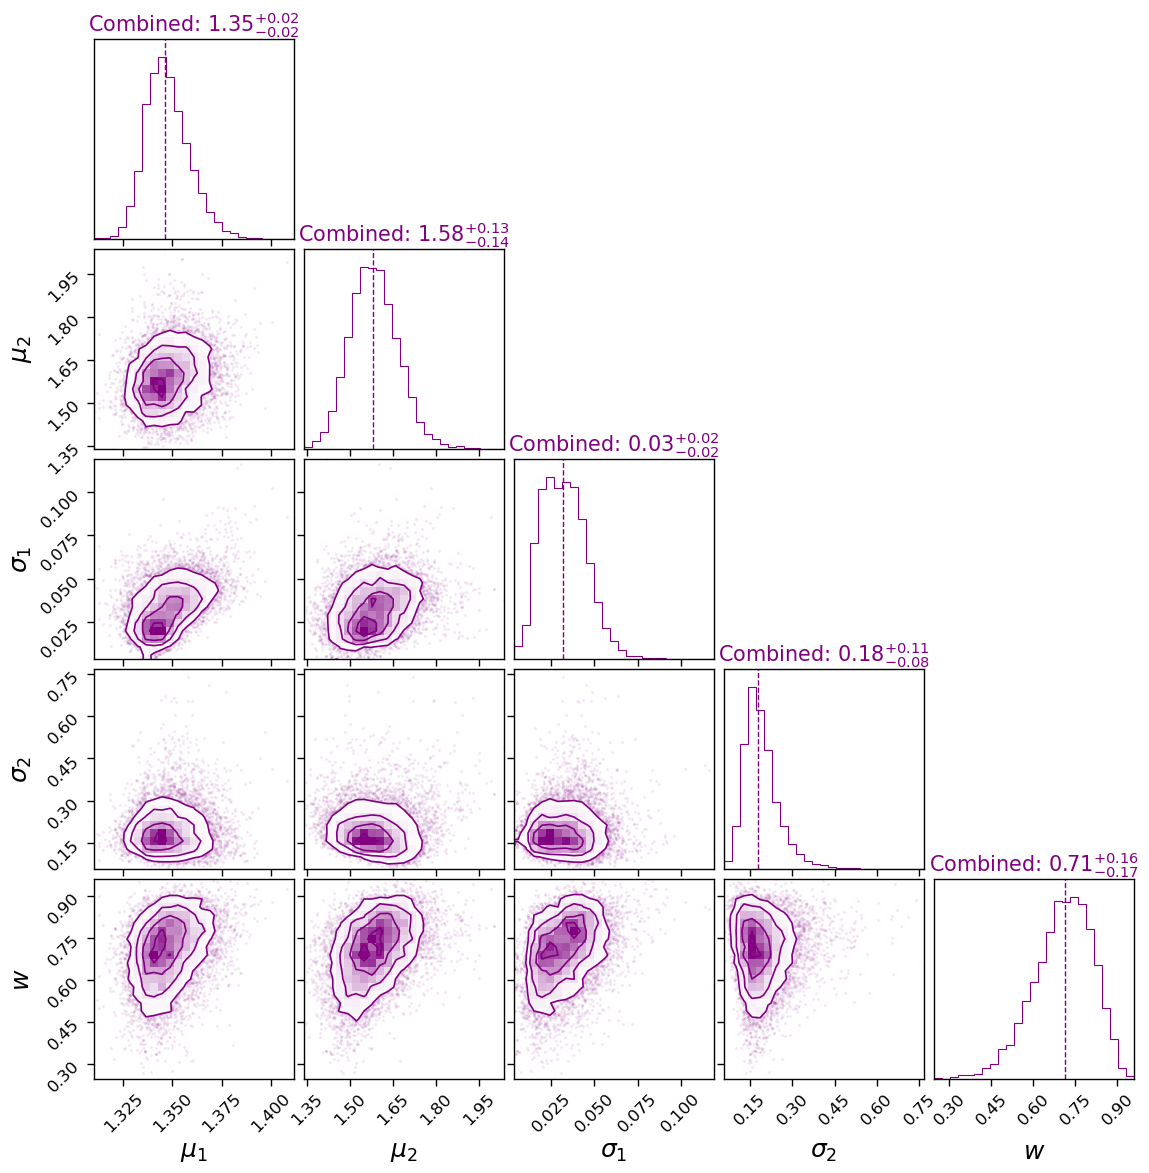

In [ ]:
# corner plot - combined only
fig = corner.corner(
    combined_samples_double_uniform,
    var_names=params,
    labels= param_labels,
    color='purple',
    show_titles=False,
    label_kwargs=dict(fontsize=18),
    bins=25
)

# Add in title manually
ndim = len(params)
axes = np.array(fig.axes).reshape((ndim, ndim))

for i, param in enumerate(params):
    ax = axes[i, i]

    combined_median = combined_medians[param]
    combined_upper = combined_upper_errors[param]
    combined_lower = combined_lower_errors[param]

    ax.text(0.5, 1.00,
            f"Combined: ${combined_median:.2f}^{{+{combined_upper:.2f}}}_{{-{combined_lower:.2f}}}$",
            fontsize=15, color='purple',
            ha='center', va='bottom', transform=ax.transAxes)
    
    ax.axvline(combined_median, color='purple', lw=1, ls='--')

plt.savefig("corner_plot_combined.png", dpi=600, bbox_inches='tight')
plt.show()

In [86]:
#Jensen-Shannon Divergence (JSD) between the two distributions
from scipy.spatial.distance import jensenshannon

def sample_from_double_gaussian(samples, size):
    """Sample from a 2-Gaussian mixture given posterior samples.
    
    Parameters:
        samples : dict
            Dictionary containing posterior samples for mu1, sigma1, mu2, sigma2, and weight.
        size : int
            Number of samples to draw.  
    Returns:
        draws : np.ndarray
            Array of sampled values from the double Gaussian mixture.   
    """
    idxs = np.random.choice(len(samples['mu1']), size, replace=True)
    draws = []
    for i in idxs:
        if np.random.rand() < samples['weight'][i]:
            draw = np.random.normal(samples['mu1'][i], samples['sigma1'][i])
        else:
            draw = np.random.normal(samples['mu2'][i], samples['sigma2'][i])
        draws.append(draw)
    return np.array(draws)


n_samples = 1000 # Number of samples to draw from each posterior
n_resamples = 1000  # Number of posterior predictive comparisons
bins = 100 

jsd_values = []

# Resample and compute JSDs
for _ in range(n_resamples):
    gaia_samples = sample_from_double_gaussian(gaia_mcmc_samples, n_samples)
    dns_samples = sample_from_double_gaussian(DNS_mcmc_samples, n_samples)

    # Histogram setup
    all_samples = np.concatenate([gaia_samples, dns_samples])
    hist_range = (all_samples.min(), all_samples.max())

    hist_gaia, bin_edges = np.histogram(gaia_samples, bins=bins, range=hist_range, density=True)
    hist_dns, _ = np.histogram(dns_samples, bins=bins, range=hist_range, density=True)

    # Normalize
    hist_gaia /= np.sum(hist_gaia)
    hist_dns /= np.sum(hist_dns)

    # JSD
    jsd = jensenshannon(hist_gaia, hist_dns, base=2) ** 2
    jsd_values.append(jsd)

# Compute median and 90% upper credible limit
jsd_values = np.array(jsd_values)
median_jsd = np.median(jsd_values)
upper_90_jsd = np.percentile(jsd_values, 90)

print(f"Median JSD: {median_jsd:.4f}")
print(f"90% Credible Limit for JSD: {upper_90_jsd:.4f}")

Median JSD: 0.0621
90% Credible Limit for JSD: 0.0770


In [87]:
from scipy.stats import wasserstein_distance
n_draws = 1000
n_samples = 1000 

wass_dists = []
for _ in range(n_draws):
    gaia_draw = sample_from_double_gaussian(gaia_mcmc_samples, n_samples)
    recycled_draw = sample_from_double_gaussian(DNS_mcmc_samples, n_samples)
    d = wasserstein_distance(gaia_draw, recycled_draw)
    wass_dists.append(d)

wass_dists = np.array(wass_dists)

# Compute the 90% credible upper limit (i.e., the 90th percentile)
upper_limit = np.percentile(wass_dists, 90)

print(f"90% credible upper limit on Wasserstein distance: {upper_limit:.4f}")

90% credible upper limit on Wasserstein distance: 0.0630
